In [1]:
import numpy as np
import pandas as pd
import os
import gc
import warnings

import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import scipy.io as sio
import torch
from torch import nn
from torch.autograd import Variable

import math

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# **Dataset**

In [3]:
 def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out = pd.read_csv(loc,**kwargs)
    return out


fname=("Local_Area_Unemployment_Statistics__LAUS_.csv","https://drive.google.com/file/d/1xoDHEKiN-y4QyZNET8SdlVRSsgW_7TLy/view?usp=sharing")
data=getfile(fname)
data.head()

local file not found; accessing Google Drive


,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate
0,State,California,01/01/1976,1976,January,N,Final,9672362,8668016,1004346,0.10
1,State,California,01/01/1976,1976,January,Y,Final,9774280,8875685,898595,0.09
2,County,Los Angeles County,01/01/1976,1976,January,N,Final,3364151,3040058,324093,0.10
3,County,Los Angeles County,01/01/1976,1976,January,Y,Final,3381856,3081806,300050,0.09
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,01/01/1976,1976,January,N,Final,3364151,3040058,324093,0.10


In [4]:
data['Date']= pd.to_datetime(data['Date'])
data['ts'] = data.Date.values.astype(np.int64) # convert datetime to pandas timestamps
data['Employment Rate']=data['Employment ']/data['Labor Force']

## **Working dataset**

In [5]:
data.to_pickle("./unemployment_working_data.pkl")  

In [6]:
pd.read_pickle("./unemployment_working_data.pkl") 

,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate,ts,Employment Rate
0,State,California,1976-01-01,1976,January,N,Final,9672362,8668016,1004346,0.10,189302400000000000,0.90
1,State,California,1976-01-01,1976,January,Y,Final,9774280,8875685,898595,0.09,189302400000000000,0.91
2,County,Los Angeles County,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90
3,County,Los Angeles County,1976-01-01,1976,January,Y,Final,3381856,3081806,300050,0.09,189302400000000000,0.91
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191122,MSA,"Yuba City, CA MSA",2022-04-01,2022,April,Y,Final,76952,72469,4483,0.06,1648771200000000000,0.94
191123,MSA,"Yuba City, CA MSA",2022-05-01,2022,May,Y,Final,76982,72704,4278,0.06,1651363200000000000,0.94
191124,MSA,"Yuba City, CA MSA",2022-06-01,2022,June,Y,Final,76953,72757,4196,0.06,1654041600000000000,0.95
191125,MSA,"Yuba City, CA MSA",2022-07-01,2022,July,Y,Final,76873,72681,4192,0.06,1656633600000000000,0.95


## **Debug dataset**

In [7]:
df_debug = data.sample(n=2000)

In [8]:
df_debug.to_pickle("./unemployment_debug_data.pkl") 

# **Visulization and Descriptive Statistics**

1. Our group aim to use data to predict California's employment rate over the next decade. So the first step, we want to see the Employment and unemployment change in California over 45 years. 

From the plot, we could see that the unemployment number remained almost constant, but the employment number kept rising. 

Both the Unemployment rate and employment rate rise and fall cyclically and become more severe.

<AxesSubplot: title={'center': 'California Employment vs. Unemployment Number Over 45 Years\n'}, xlabel='Year', ylabel='Count'>

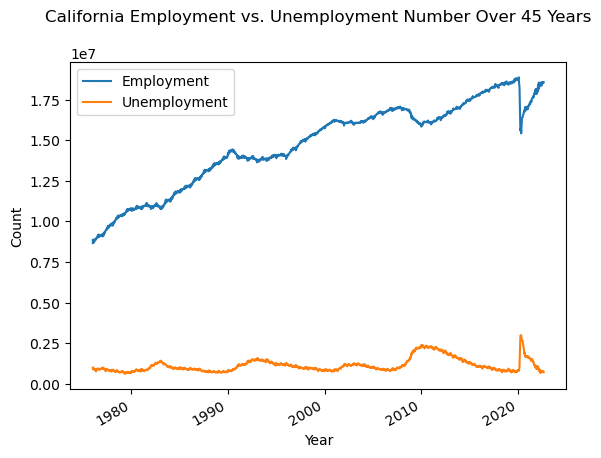

In [9]:
#data['Employment Rate']=data['Employment']/data['Labor Force']
data.columns = ['Area Type', 'Area Name', 'Date', 'Year', 'Month',
       'Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)',
       'Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate','ts','Employment Rate']
subData_County = data.loc[(data['Area Type']=='County')]
subData_State = data.loc[(data['Area Type']=='State')]

Pre = subData_State[['Date', 'Employment','Unemployment']]
Pre.set_index(["Date"], inplace=True)
Pre.plot(title="California Employment vs. Unemployment Number Over 45 Years\n", ylabel="Count", xlabel="Year")

<AxesSubplot: title={'center': 'California Employment Rate Over 45 Years\n'}, xlabel='Year', ylabel='rate'>

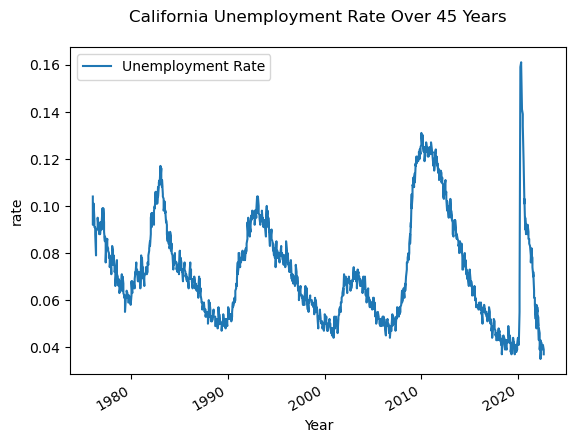

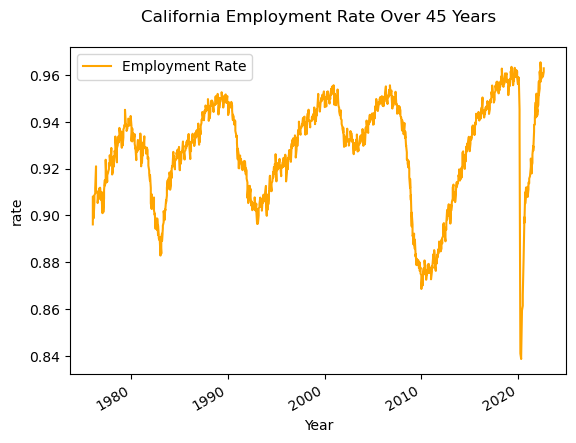

In [10]:
Pre1 = subData_State[['Date','Unemployment Rate']]
Pre1.set_index(["Date"], inplace=True)
Pre1.plot(title="California Unemployment Rate Over 45 Years\n", ylabel="rate", xlabel="Year")
Pre2 = subData_State[['Date','Employment Rate']]
Pre2.set_index(["Date"], inplace=True)
Pre2.plot(title="California Employment Rate Over 45 Years\n", ylabel="rate", xlabel="Year", color = 'orange')

2. The average unemplyment rates and emplyment rates of California Counties in the last 45 years.

In [11]:
ax=plt.figure(figsize=(10,22))
ax = sns.barplot(subData_County["Unemployment Rate"],                 
                 y=subData_County["Area Name"],color="y")
ax.set_title('Avg. Unemployment rates of California Counties in last 45 years')
ax.set(xlabel='Unemployment Rate', ylabel='County')

ax2=plt.figure(figsize=(10,22))
ax2 = sns.barplot(subData_County["Employment Rate"],                 
                 y=subData_County["Area Name"])
ax2.set_title('Avg. Employment rates of California Counties in last 45 years')
ax2.set(xlabel='Employment Rate', ylabel='County')

TypeError: Vertical orientation requires numeric `y` variable.

<Figure size 1000x2200 with 0 Axes>

 3. show average unemployment and statistics in different categories.

In [ ]:
def plt_show(X_name, Y_name, dic, Z_name):
  
  XY = data[[X_name,Y_name]]
  X = dic.values()
  Y = []
  num = []
  for i in range(len(X)):
    Y_cat = XY[XY[X_name] == dic[i]][Y_name]
    Y.append(Y_cat.mean())
    num.append(len(Y_cat))
   #print(str(len(Y_cat)) + ' cases with '+ X_name + ' taking value ' + dic[i])

  plt.pie(num, labels = X, autopct='%1.1f%%')
  title1 = 'Cases in different ' + X_name
  plt.title(title1)
  plt.show()

  title2 = 'Average ' + Y_name + ' in different ' + X_name
  plt.bar(X,Y)
  plt.axhline(XY[Y_name].mean(), label = 'Mean of '+ Y_name, ls = ':')
  plt.legend(loc = 'best')
  plt.xlabel(X_name)
  plt.ylabel('Average ' + Y_name)
  plt.title(title2)
  plt.show()

  XZ = data[[X_name,Z_name]]
  X = dic.values()
  Z = []
  num = []
  for i in range(len(X)):
    Z_cat = XZ[XZ[X_name] == dic[i]][Z_name]
    Z.append(Z_cat.mean())
    num.append(len(Z_cat))

  title3 = 'Average ' + Z_name + ' in different ' + X_name
  plt.bar(X,Z,color='orange')
  plt.axhline(XZ[Z_name].mean(), label = 'Mean of '+ Z_name, ls = ':')
  plt.legend(loc = 'best')
  plt.xlabel(X_name)
  plt.ylabel('Average ' + Z_name)
  plt.title(title3)
  plt.show()

**Area Type**

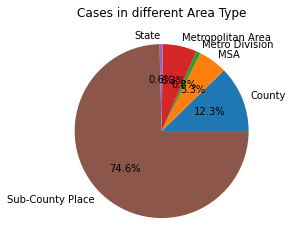

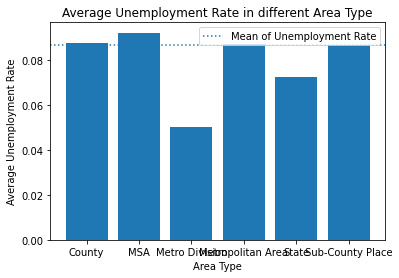

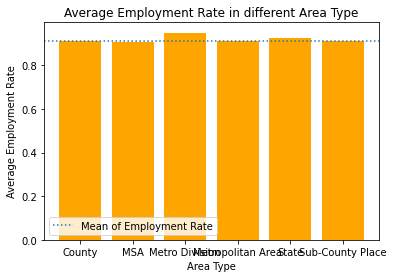

In [ ]:
X_name = 'Area Type'
Y_name = 'Unemployment Rate'
Z_name = 'Employment Rate'
dic = {0:'County', 1:'MSA', 2:'Metro Division', 3:'Metropolitan Area', 4:'State', 5:'Sub-County Place'}
plt_show(X_name, Y_name, dic, Z_name)

**Month**

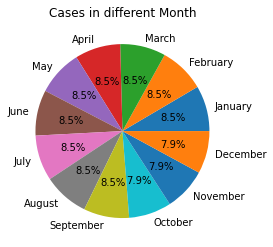

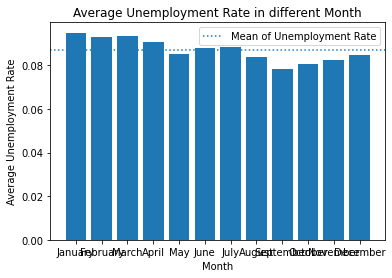

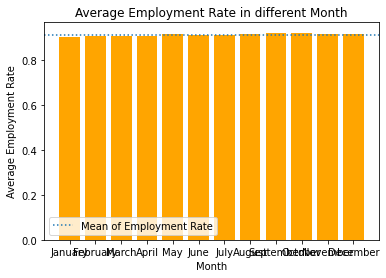

In [ ]:
X_name = 'Month'
Y_name = 'Unemployment Rate'
Z_name = 'Employment Rate'
dic = {0:'January', 1:'February', 2:'March', 3:'April', 4:'May', 5:'June', 6:'July', 7:'August', 
       8:'September', 9:'October', 10:'November', 11:'December'}
plt_show(X_name, Y_name, dic, Z_name)

**Seasonally Adjusted (Y/N)**

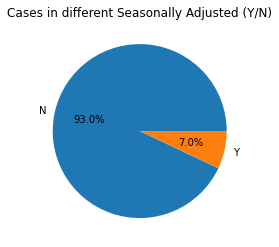

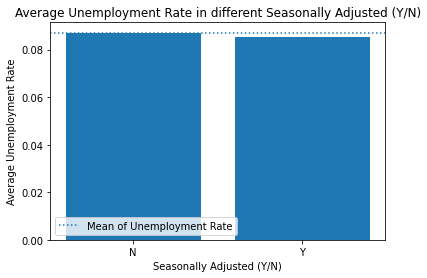

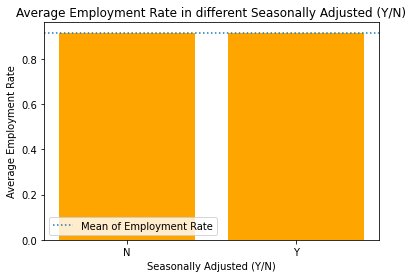

In [ ]:
X_name = 'Seasonally Adjusted (Y/N)'
Y_name = 'Unemployment Rate'
Z_name = 'Employment Rate'
dic = {0:'N', 1:'Y'}
plt_show(X_name, Y_name, dic, Z_name)

**Status (Preliminary / Final)**

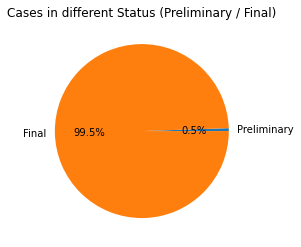

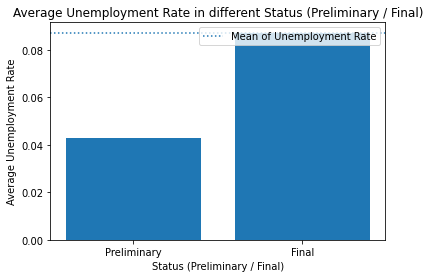

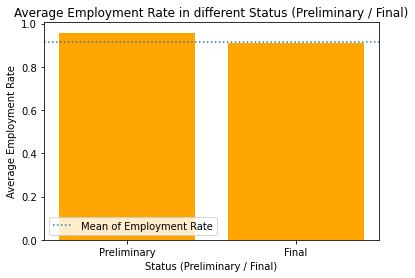

In [ ]:
X_name = 'Status (Preliminary / Final)'
Y_name = 'Unemployment Rate'
Z_name = 'Employment Rate'
dic = {0:'Preliminary', 1:'Final'}
plt_show(X_name, Y_name, dic, Z_name)



From the plots above, compared to the unemployment rate, the employment rate nearly changes in categories such as Month and Seasonally adjusted and changes slightly in categories such as area type and status (Preliminary / Final). 

The reason is that the change in the employment rate is small relative to the employment rate itself so we are going to **predict unemployment rate** instead of employment. Their relation is: employment rate + unemployment rate = 1.

# Linear regression benchmark


In [ ]:
df = pd.read_pickle("./unemployment_working_data.pkl") 
df.head()

,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate,ts,Employment Rate
0,State,California,1976-01-01,1976,January,N,Final,9672362,8668016,1004346,0.10,189302400000000000,0.90
1,State,California,1976-01-01,1976,January,Y,Final,9774280,8875685,898595,0.09,189302400000000000,0.91
2,County,Los Angeles County,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90
3,County,Los Angeles County,1976-01-01,1976,January,Y,Final,3381856,3081806,300050,0.09,189302400000000000,0.91
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90


In [ ]:
data.columns = ['Area Type', 'Area Name', 'Date', 'Year', 'Month',
       'Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)',
       'Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate','ts','Employment Rate']
cat_col = ['Area Type', 'Area Name','Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)']
time_col = ['Date', 'Year', 'Month']
num_col = ['Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate', 'ts', 'Employment Rate']

In [ ]:
data["Area Type"].value_counts()

Sub-County Place     142596
County                23523
Metropolitan Area     12126
MSA                   10192
Metro Division         1568
State                  1122
Name: Area Type, dtype: int64

In [ ]:
data["Area Name"].value_counts()

In [ ]:
data["Seasonally Adjusted (Y/N)"].value_counts()

N    177684
Y     13443
Name: Seasonally Adjusted (Y/N), dtype: int64

In [ ]:
data["Status (Preliminary / Final)"].value_counts()

Final          190074
Preliminary      1023
Prelim             30
Name: Status (Preliminary / Final), dtype: int64

In [ ]:
subData = data.loc[(data['Area Type']=='State')]
subData = subData.loc[(subData['Seasonally Adjusted (Y/N)']=='N')]
subData = subData.loc[(subData['Status (Preliminary / Final)']=='Final')]

In [ ]:
subData

,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate,ts,Employment Rate
0,State,California,1976-01-01,1976,January,N,Final,9672362,8668016,1004346,0.10,189302400000000000,0.90
6,State,California,1977-01-01,1977,January,N,Final,10071966,9074522,997444,0.10,220924800000000000,0.90
12,State,California,1978-01-01,1978,January,N,Final,10613102,9737384,875718,0.08,252460800000000000,0.92
18,State,California,1979-01-01,1979,January,N,Final,11098776,10309724,789052,0.07,283996800000000000,0.93
24,State,California,1980-01-01,1980,January,N,Final,11440457,10659639,780818,0.07,315532800000000000,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174252,State,California,2017-12-01,2017,December,N,Final,19113100,18290000,823100,0.04,1512086400000000000,0.96
175275,State,California,2018-12-01,2018,December,N,Final,19311900,18499900,812000,0.04,1543622400000000000,0.96
176298,State,California,2019-12-01,2019,December,N,Final,19493000,18742400,750600,0.04,1575158400000000000,0.96
177321,State,California,2020-12-01,2020,December,N,Final,18613700,16929300,1684400,0.09,1606780800000000000,0.91


In [ ]:
Pre = subData[['Date', 'Unemployment Rate']]
Pre.set_index(["Date"], inplace=True)
Pre


,Unemployment Rate
Date,
1976-01-01,0.10
1977-01-01,0.10
1978-01-01,0.08
1979-01-01,0.07
1980-01-01,0.07
...,...
2017-12-01,0.04
2018-12-01,0.04
2019-12-01,0.04


In [ ]:
dataset = Pre.values

<Figure size 864x576 with 0 Axes>

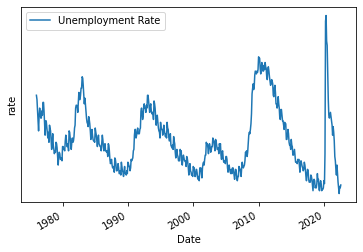

In [ ]:
plt.figure(figsize=(12, 8))
Pre.plot()
plt.ylabel('rate')
plt.yticks(np.arange(0, 1, 1))
plt.show()

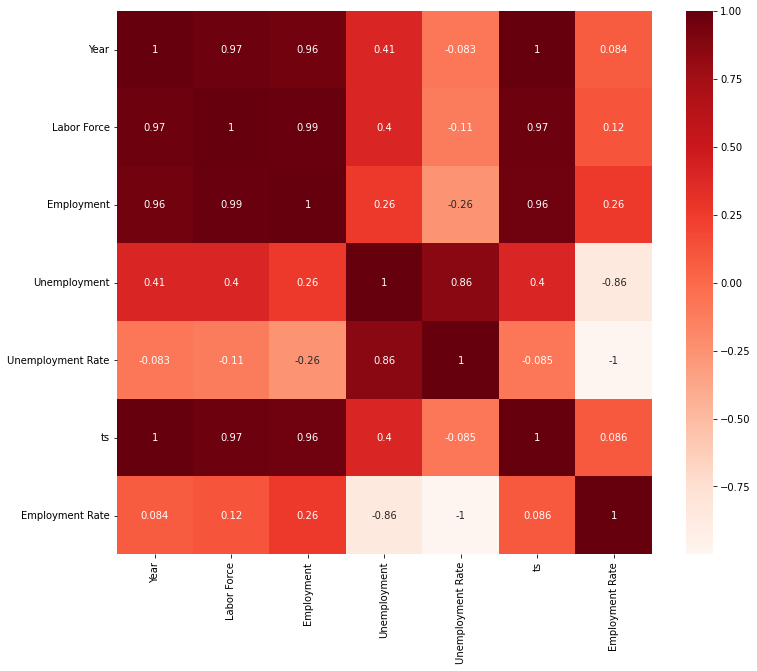

In [ ]:
plt.figure(figsize=(12,10))
cor = subData.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# -----------------------------------------
# Linear Regression Benchmark:

import datetime as dt

X = subData.drop(['Area Type','Area Name','Month','Year','Seasonally Adjusted (Y/N)','Status (Preliminary / Final)','Employment','Unemployment', 'Unemployment Rate', 'ts', 'Employment Rate'],axis=1)
y = subData['Unemployment Rate']

# Convert datetime object to numerical value
X['Date']=X['Date'].map(dt.datetime.toordinal)

# noemalize
X['Date'] = (X['Date'] - X['Date'].mean())/X['Date'].std()
X['Labor Force'] = (X['Labor Force'] - X['Labor Force'].mean())/X['Labor Force'].std()

# X_number   = X.select_dtypes(include='number')
# X_category = X.select_dtypes(exclude='number')

# # One-hot-encode categorical values
# X_category = pd.get_dummies(X_category)
# X_number = (X_number - X_number.mean())/X_number.std()
# X = pd.concat([X_number,X_category],axis=1)
X.head()

,Date,Labor Force
0,-1.73,-2.25
6,-1.65,-2.10
12,-1.58,-1.91
18,-1.50,-1.73
24,-1.43,-1.61


In [ ]:
from sklearn.linear_model import LinearRegression

# Perform Linear Regression
lr = LinearRegression()
lr.fit(X,y)
R2 = lr.score(X,y)
# Linear Regression score
print('R-squared =',R2.round(2))

R-squared = 0.03


In [ ]:
# best feature parameters
coef = lr.coef_
coef = pd.Series(coef,index=X.columns)
coef.sort_values(ascending=False).round(2)

Date           0.01
Labor Force   -0.01
dtype: float64

# RNN Test


In [48]:
subData = data.loc[(data['Area Type']=='State')]
subData = subData.loc[(subData['Seasonally Adjusted (Y/N)']=='N')]
subData = subData.loc[(subData['Status (Preliminary / Final)']=='Final')]

df = subData_State[['Date', 'Unemployment Rate']]
df.set_index(["Date"], inplace=True)
df = df.sort_index(ascending=True)
for i in range(6):
    j = 'R-' + str(i)
    df[j] = df['Unemployment Rate'].shift(i)
df = df.dropna()
df


,Unemployment Rate,R-0,R-1,R-2,R-3,R-4,R-5
Date,,,,,,,
1976-03-01,0.09,0.09,0.09,0.10,0.09,0.09,0.10
1976-04-01,0.09,0.09,0.09,0.09,0.10,0.09,0.09
1976-04-01,0.09,0.09,0.09,0.09,0.09,0.10,0.09
1976-05-01,0.08,0.08,0.09,0.09,0.09,0.09,0.10
1976-05-01,0.09,0.09,0.08,0.09,0.09,0.09,0.09
...,...,...,...,...,...,...,...
2022-07-01,0.04,0.04,0.04,0.04,0.04,0.04,0.04
2022-08-01,0.04,0.04,0.04,0.04,0.04,0.04,0.04
2022-08-01,0.04,0.04,0.04,0.04,0.04,0.04,0.04


In [19]:
def creat_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i: (i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)

In [20]:
look_back = 5
data_x, data_y = creat_dataset(dataset, look_back)


NameError: name 'dataset' is not defined

In [21]:
class LstmRNN(nn.Module):
    """
        Parameters：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
 
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)  # utilize the LSTM model in torch.nn
        self.linear1 = nn.Linear(hidden_size, output_size) #
 
    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s * b, h)
        x = self.linear1(x)
        x = x.view(s, b, -1)
        return x

In [47]:
device = torch.device("cpu")
 
if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')


No GPU available, training on CPU.


In [49]:
'''
data_x = np.array(Pre.astype('float32'))
data_y = np.array(Pre.astype('float32'))
 
data_len = len(data_x)
t = np.linspace(0, data_len, data_len + 1)
 
train_data_ratio = 0.8  # Choose 80% of the data for training
train_data_len = int(data_len * train_data_ratio)
 
#train_x = data_x[5:train_data_len]
#train_y = data_y[5:train_data_len]
train_x = data_x[train_data_len]
train_y = data_y[train_data_len]
#t_for_training = t[5:train_data_len]
 
test_x = data_x[train_data_len:]
test_y = data_y[train_data_len:]
t_for_testing = t[train_data_len:]
'''

In [57]:
train_x.shape

(2,)

In [44]:
# ----------------- train -------------------
INPUT_FEATURES_NUM = 5
OUTPUT_FEATURES_NUM = 1
train_x_tensor = train_x.reshape(-1, 1, INPUT_FEATURES_NUM)  # set batch size to 1
train_y_tensor = train_y.reshape(-1, 1, OUTPUT_FEATURES_NUM)  # set batch size to 1
 
# transfer data to pytorch tensor
train_x_tensor = torch.from_numpy(train_x_tensor)
train_y_tensor = torch.from_numpy(train_y_tensor)

ValueError: cannot reshape array of size 2 into shape (1,5)

In [56]:
test_x.reshape(-1,1,5)

array([[[16095200.,  1043900., 16195400.,  1121300., 16092900.]],

       [[ 1175200., 16183800.,  1138600., 16094500.,  1174700.]],

       [[16465800.,   995700., 16376900.,  1034000., 16783900.]],

       [[  873400., 16675300.,   917000., 16979600.,   788900.]],

       [[16870400.,   860800., 17040900.,   964200., 16976300.]],

       [[ 1017600., 16877600.,  1469500., 16755400.,  1528400.]],

       [[16059800.,  2208300., 16007600.,  2235700., 16153000.]],

       [[ 2217000., 16092500.,  2286200., 16397400.,  2119400.]],

       [[16320800.,  2149800., 16774200.,  1819000., 16678600.]],

       [[ 1857900., 16936300.,  1596300., 16951100.,  1602700.]],

       [[17496100.,  1301500., 17413800.,  1346900., 17766500.]],

       [[ 1071700., 17724500.,  1099900., 18074800.,  1017000.]],

       [[18028400.,  1043300., 18375400.,   829200., 18316600.]],

       [[  887500., 18587800.,   774600., 18483700.,   824800.]],

       [[18781300.,   747700., 18680000.,   791400., 17041400.

In [ ]:
lstm_model = LstmRNN(INPUT_FEATURES_NUM, 20, output_size=OUTPUT_FEATURES_NUM, num_layers=1)  # 20 hidden units
print('LSTM model:', lstm_model)
print('model.parameters:', lstm_model.parameters)
print('train x tensor dimension:', Variable(train_x_tensor).size())
 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
 
prev_loss = 1000
max_epochs = 2000

In [ ]:
train_x_tensor = train_x_tensor.to(device)
 
for epoch in range(max_epochs):
    output = lstm_model(train_x_tensor).to(device)
    loss = criterion(output, train_y_tensor)
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
 
    if loss < prev_loss:
        torch.save(lstm_model.state_dict(), 'lstm_model.pt')  # save model parameters to files
        prev_loss = loss
 
    if loss.item() < 1e-4:
        print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch + 1, max_epochs, loss.item()))
        print("The loss value is reached")
        break
    elif (epoch + 1) % 100 == 0:
        print('Epoch: [{}/{}], Loss:{:.5f}'.format(epoch + 1, max_epochs, loss.item()))

In [ ]:
# prediction on training dataset
pred_y_for_train = lstm_model(train_x_tensor).to(device)
pred_y_for_train = pred_y_for_train.view(-1, OUTPUT_FEATURES_NUM).data.numpy()
 
# ----------------- test -------------------
lstm_model = lstm_model.eval()  # switch to testing model
 
# prediction on test dataset
test_x_tensor = test_x.reshape(-1, 1,
                                   INPUT_FEATURES_NUM)
test_x_tensor = torch.from_numpy(test_x_tensor)  
test_x_tensor = test_x_tensor.to(device)
 
pred_y_for_test = lstm_model(test_x_tensor).to(device)
pred_y_for_test = pred_y_for_test.view(-1, OUTPUT_FEATURES_NUM).data.numpy()
 
loss = criterion(torch.from_numpy(pred_y_for_test), torch.from_numpy(test_y))
print("test loss：", loss.item())

In [ ]:
# ----------------- plot -------------------
plt.figure()
plt.plot(t_for_training, train_y, 'b', label='y_trn')
plt.plot(t_for_training, pred_y_for_train, 'y--', label='pre_trn')
 
plt.plot(t_for_testing, test_y, 'k', label='y_tst')
plt.plot(t_for_testing, pred_y_for_test, 'm--', label='pre_tst')
 
plt.xlabel('t')
plt.ylabel('Vce')
plt.show()


# RNN


In [ ]:
RNN_df = pd.read_pickle("./unemployment_working_data.pkl") 
RNN_df.head()